**Проект: вариант 1**

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm, shapiro
from tqdm.auto import tqdm

from datetime import datetime, date, time
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

***Задание 1***

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных 

In [2]:
# чтение файлов
reg_data = pd.read_csv(r'C:\Users\Пользователь\OneDrive\Документы\Final_project_data\problem1-reg_data.csv', sep =';')
auth_data = pd.read_csv(r'C:\Users\Пользователь\OneDrive\Документы\Final_project_data\problem1-auth_data.csv', sep =';')

In [3]:
# проверка наличия пропущенных значений
print(reg_data.isna().any())
print(auth_data.isna().any())

reg_ts    False
uid       False
dtype: bool
auth_ts    False
uid        False
dtype: bool


In [4]:
# выводим типы дынных
print(reg_data.dtypes)
print(auth_data.dtypes)

reg_ts    int64
uid       int64
dtype: object
auth_ts    int64
uid        int64
dtype: object


In [5]:
# перевод даты в необходимый формат
auth_data['auth_day'] = pd.to_datetime(auth_data['auth_ts'],unit='s').astype("datetime64[D]")
reg_data['reg_day'] = pd.to_datetime(reg_data['reg_ts'],unit='s').astype("datetime64[D]")

In [6]:
# поиск минимальных и максимальных дат в датасете
print('Данные о регистрации: ', reg_data.reg_day.min(), '-',  reg_data.reg_day.max())
print('Данные о действиях: ', auth_data.auth_day.min(), '-',  auth_data.auth_day.max())

Данные о регистрации:  1998-11-18 00:00:00 - 2020-09-23 00:00:00
Данные о действиях:  1998-11-18 00:00:00 - 2020-09-23 00:00:00


In [7]:
# функция расчета retention
def retention_of_players(reg_data, auth_data):
    
    reg_data = pd.read_csv(r'C:\Users\Пользователь\OneDrive\Документы\Final_project_data\problem1-reg_data.csv', sep =';')
    auth_data = pd.read_csv(r'C:\Users\Пользователь\OneDrive\Документы\Final_project_data\problem1-auth_data.csv', sep =';')

    auth_data['auth_day'] = pd.to_datetime(auth_data['auth_ts'],unit='s').astype("datetime64[D]")
    reg_data['reg_day'] = pd.to_datetime(reg_data['reg_ts'],unit='s').astype("datetime64[D]")
    
    # начальная и конечгая дата для построения когорт
    data_start = '2020-09-01'
    data_end = '2020-09-23'
    
    reg_data_test = reg_data.query('@data_start <= reg_day <= @data_end')
    
    df = reg_data_test
    
    # формируем датасет для выбранных дат
    df = auth_data.merge(reg_data_test, how='left', on='uid')
    
    df = df[['uid', 'reg_day', 'auth_day']]
    df['diff'] = df.auth_day - df.reg_day
    df['diff'] = df['diff'].dt.days
    
    
    # считаем активных пользователей
    cohorts = df.groupby(['reg_day','diff'], as_index=False) \
                .aggregate({'uid':'nunique'}) \
                .rename(columns={'uid':'active_users',
                                 'reg_day':'cohorts'})
    # отбираем когорты и определяем их размер
    reg_users = cohorts[cohorts['diff'] == 0]
    reg_users = reg_users[['cohorts','active_users']] \
                .rename(columns={'active_users':'cohort_users'})
    # формируем датасет
    cohorts = cohorts.merge(reg_users, on='cohorts')
    
    cohorts['cohorts'] = cohorts.cohorts.dt.to_period('d')

    # считаем retention
    cohorts['retention'] = round(100 * cohorts['active_users'] / cohorts['cohort_users'], 2)
    retention = cohorts.pivot_table(index= 'cohorts',
                                    columns='diff',
                                    values='retention')
    # визуализируем результат
    plt.figure(figsize=[18, 10])
    plt.title('Retention Rate')
    heatmap = sns.heatmap(retention[range(1, len(retention.columns))], 
                    annot=True, cmap="viridis", fmt='g', square=True, linewidth=0.5, linecolor="#111") 
        
    return heatmap

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='diff', ylabel='cohorts'>

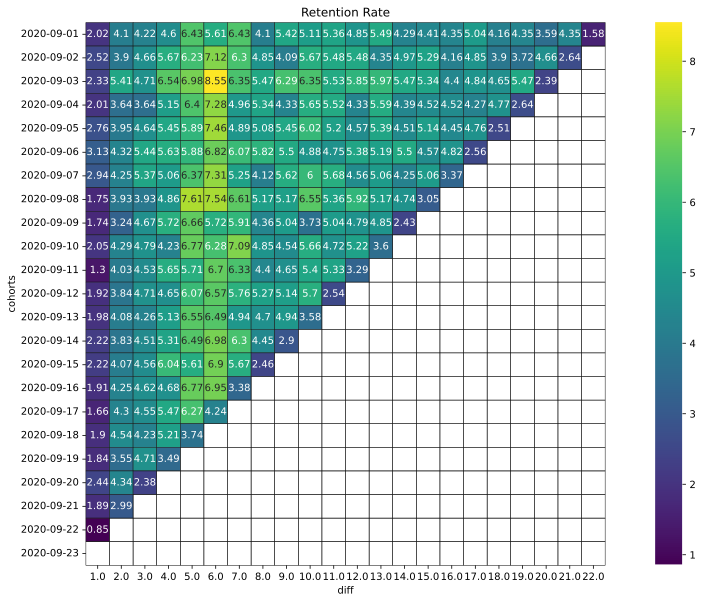

In [8]:
retention_of_players(reg_data, auth_data)

**Заключение:**

Наиболее высокие показатели retention наблюдаются на 5-7 день после регистрации. Возможно игроку предоставляется бонус при использовании игры в течение недели. Для установления более точной причины необходима дополнительная информация.

**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [9]:
# чтение файла
task_2 = pd.read_csv(r'C:\Users\Пользователь\OneDrive\Документы\Final_project_data\Task_2.csv', sep =';')
task_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [10]:
# выводим типы данных
task_2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [11]:
# проверяем наличие пропущенных значений
task_2.isna().any()

user_id      False
revenue      False
testgroup    False
dtype: bool

In [12]:
# считаем доход в контрольно и тестовой группах
task_2 \
    .groupby('testgroup') \
    .agg({'revenue' : 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


In [13]:
# выделяем тестовую и контрольную группу из датасета
group_a = task_2.query("testgroup == 'a'")
group_b = task_2.query("testgroup == 'b'")

# выделяем платящих пользователей из каждой группы
group_a_pay = group_a.query('revenue > 0')
group_b_pay = group_b.query('revenue > 0')

In [14]:
# посмотрим на ARPU и распределение выручки с платящих игроков 
print(f'A GROUP\n ARPU: {group_a.revenue.mean()} \n{group_a[group_a.revenue > 0].revenue.describe()}')

print(f'B GROUP\n ARPU: {group_b.revenue.mean()} \n{group_b[group_b.revenue > 0].revenue.describe()}')

A GROUP
 ARPU: 25.413719736965806 
count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64
B GROUP
 ARPU: 26.75128659327863 
count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64


C:\Anakonda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue'>

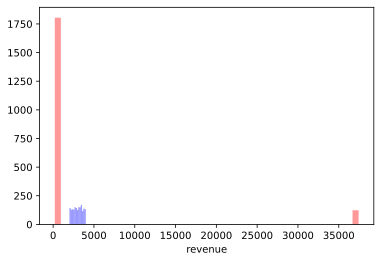

In [15]:
# визуализируем распределения оплат пользователей в тестовой и контрольной группах
sns.distplot(group_a[group_a.revenue > 0].revenue, kde=False, color = 'red') # контрольная группа
sns.distplot(group_b[group_b.revenue > 0].revenue, kde=False, color = 'blue') # тестовая группа

Text(0, 0.5, '')

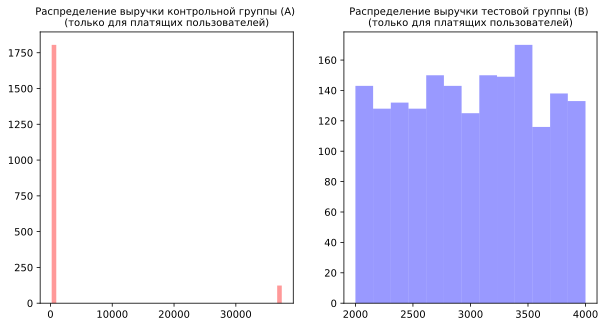

In [16]:
plt.figure(figsize=(10, 5))


plt.subplot(1,2,1)
sns.distplot(group_a[group_a.revenue > 0].revenue, kde=False, color ='red')
plt.title('Распределение выручки контрольной группы (А) \n(только для платящих пользователей)',fontsize=10)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
sns.distplot(group_b[group_b.revenue > 0].revenue, kde=False, color='blue')
plt.title('Распределение выручки тестовой группы (В) \n(только для платящих пользователей)',fontsize=10);
plt.xlabel('')
plt.ylabel('')

По графику платящих пользователей в контрольной группе видно, что значительную часть дохода вероятно приносят пользователи оплачивающие большую сумму

In [17]:
# найдем какой процент пользователей из контрольной группы приносит основную часто дохода
revenue_a_95 = int(np.percentile(group_a_pay.revenue, q=95))
group_a_pay.query('revenue >= @revenue_a_95').revenue.sum() / group_a_pay.revenue.sum()

0.7339574147290919

В контрольной группе всего 5% пользователей приносят 73% дохода

Визуально распределения контрольной и тестовой групп не являются нормальными, поэтому проверим распределения на нормальность

In [18]:
#тест Шапиро-Уилка для проверки нормальности распределений
print('Shapiro', shapiro(group_a_pay.revenue))
print('Shapiro', shapiro(group_b_pay.revenue))

Shapiro ShapiroResult(statistic=0.26679253578186035, pvalue=0.0)
Shapiro ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)


Распределения не являются нормальными, поэтому проводить тест Манна-Утни нецелесообразно.

Проверим метрики ARPU и ARPPU методом Bootstrap, отвергаем или принимаем H0 при p-value < 0.05

In [19]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=[8, 8])
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--', color='black')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

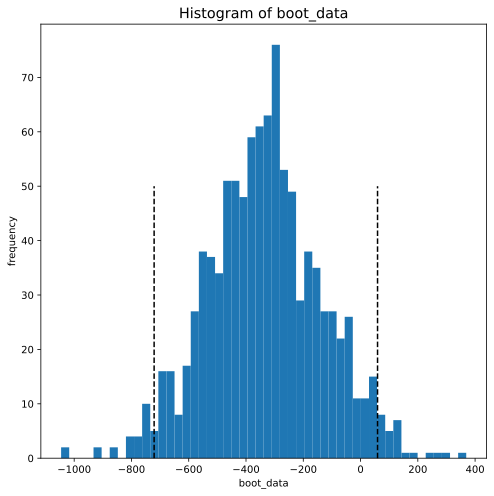

Результат bootstrap-теста для ARPPU:
p-value: 0.09


In [20]:
#Сравним выборки по ARPPU
booted_data = get_bootstrap(group_a_pay.revenue, group_b_pay.revenue, boot_it = 1000)
print("Результат bootstrap-теста для ARPPU:")
print(f'p-value: {booted_data["p_value"]:.2f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

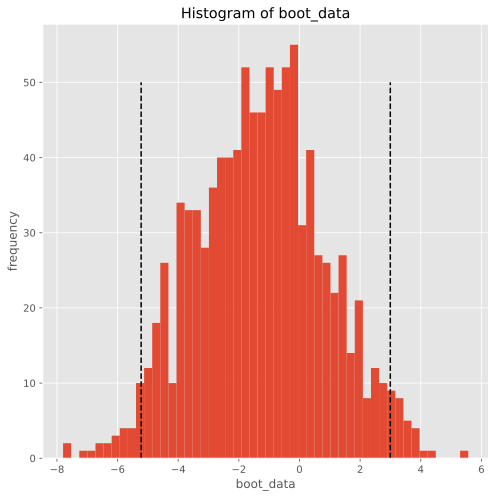

Результат bootstrap-ARPU:
p-value: 0.55


In [21]:
# Сравним выборки по метрике ARPU 
booted_data = get_bootstrap(group_a.revenue, group_b.revenue, boot_it = 1000)
print("Результат bootstrap-ARPU:")
print(f'p-value: {booted_data["p_value"]:.2f}')

В получившихся графиках по ARPU и ARPPU 0 входит в доверительный интервал, значит статистически значимой разницы между контрольной и тестовой группами нет

In [22]:
# Выведем основные метрики
# Расчитаем конверсию
cr_a = group_a_pay.shape[0] / group_a.shape[0] * 100
cr_b = group_b_pay.shape[0] / group_b.shape[0] * 100

# Расчитаем абсолютный доход для каждой группы
revenue_a = group_a.revenue.sum()
revenue_b = group_b.revenue.sum()

# Расчитаем ARPU
arpu_a = revenue_a / group_a.shape[0] # контрольная группа
arpu_b = revenue_b / group_b.shape[0] # тестовая группа

# Расчитаем ARPPU
arppu_a = revenue_a / group_a.query('revenue > 0').shape[0]
arppu_b = revenue_b / group_b.query('revenue > 0').shape[0]

print('Доход в контрольной группе (А) - ', revenue_a)
print('Доход в тестовой группе (В) - ', revenue_b)
print('Доход в тестовой группе увеличился на', round((revenue_b - revenue_a)*100 / revenue_b, 1), '%\n')

print('Конверсия контрольной группы (А) - ', cr_a)
print('Конверсия тестовой группы (В) - ', cr_b)
print('Конверсия в тестовой группе уменьшилась на ', round(cr_a - cr_b, 2), '% \n')

print('ARPU контрольной группы (А) - ', arpu_a)
print('ARPU тестовой группы - (В) - ', arpu_b)
print('ARPU в тестовой группе увеличился на', round((arpu_b - arpu_a)*100 / arpu_a, 1), '%\n')

print('ARPPU контрольной группы (А) - ', arppu_a)
print('ARPPU тестовой группы - (В) ', arppu_b)
print('ARPPU в тестовой группе увеличился на', round((arppu_b - arppu_a)*100 / arppu_b, 1), '%\n')

Доход в контрольной группе (А) -  5136189
Доход в тестовой группе (В) -  5421603
Доход в тестовой группе увеличился на 5.3 %

Конверсия контрольной группы (А) -  0.9539690157988748
Конверсия тестовой группы (В) -  0.8906235351586593
Конверсия в тестовой группе уменьшилась на  0.06 % 

ARPU контрольной группы (А) -  25.413719736965806
ARPU тестовой группы - (В) -  26.75128659327863
ARPU в тестовой группе увеличился на 5.3 %

ARPPU контрольной группы (А) -  2663.9984439834025
ARPPU тестовой группы - (В)  3003.6581717451522
ARPPU в тестовой группе увеличился на 11.3 %



**ЗАКЛЮЧЕНИЕ**

Проведенный анализ данных показал, что распределение платящих пользователей в контрольной (А) и тестовой (В) группах не являлось нормальным. Особенно разброс значений наблюдался в контрольной группе, где значения либо низкие, либо высокие.

Для сравнения двух методов был применен непараметрический тест Bootstrap, сравнение производилось по метрикам ARPU и ARPPU.
Результат Bootstrap анализа не позволил отвергнуть H0 о равенстве средних у платящих пользователей, т.е. статистически значимых различий между метриками ARPU и ARPPU в группах нет, несмотря на то, что доход в тестовой группе увеличился на 5,3%., а также выросли метрики ARPU (на 5,3%) и ARPPU (на 11,3%). Показатель конверсии в тестовой группе, наоборот, снизился на 0,06%.

Не рекомендуется выкатывать тестовое предложение, необходимо провести повторный А/В тест, а также перед этим провести А/А тест, для исключения ошибки в выборе групп для эксперимента и воздействии  неучтенных факторов, которые влияют на пользователей в группах, например, в контрольную группу попали пользователи премиум сегмента, а в тестовую только средний сегмент, либо пользватели в группах значительно отличаются по давности регистрации/использования приложения.

В обновленном тесте проверить метрики ARPU, ARPPU, CR и Retention.